## Stock Chart Trend Classification

#### Importing dependencies

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import os
from dask import bag
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from pathlib import Path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

### Exploratory Data Analysis

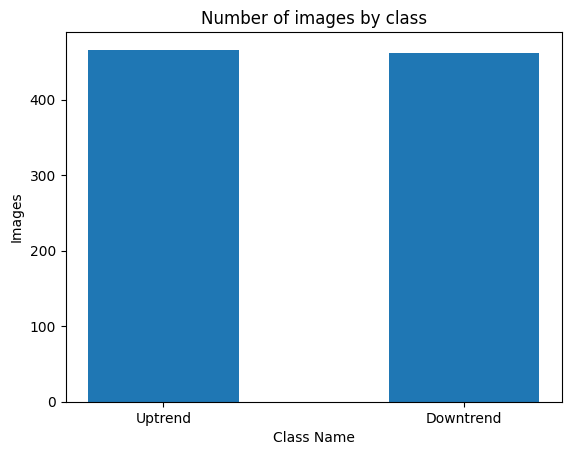

In [2]:
uptrend_dir = r"/kaggle/input/stock-chart-classification-dataset/chart trend dataset/uptrend"
downtrend_dir = r"/kaggle/input/stock-chart-classification-dataset/chart trend dataset/downtrend"

number_classes = {
    'Uptrend': len(os.listdir(uptrend_dir)),
    'Downtrend': len(os.listdir(downtrend_dir))
}

plt.bar(number_classes.keys(), number_classes.values(), width=0.5)
plt.title("Number of images by class")
plt.xlabel("Class Name")
plt.ylabel("Images")
plt.show()

Checking the pixel distribution

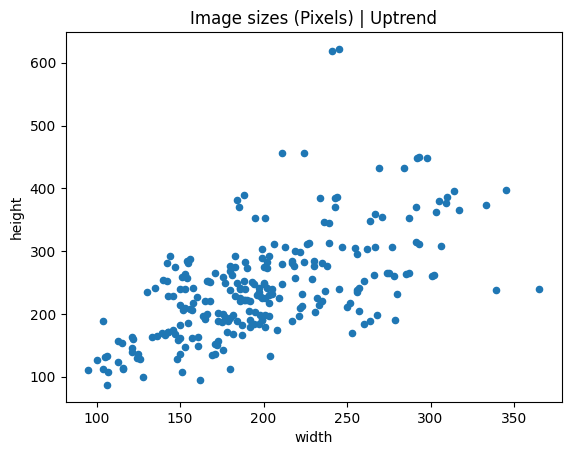

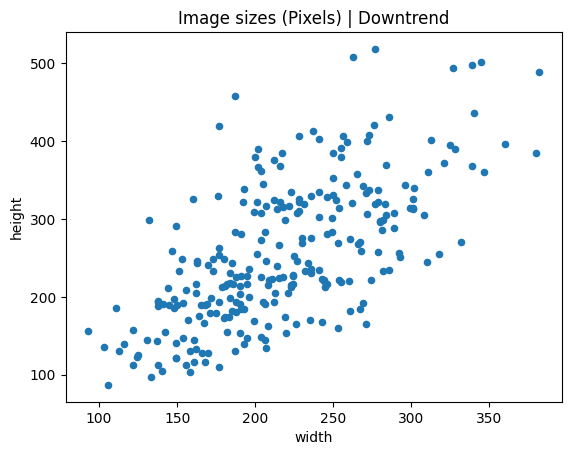

In [3]:
directories = {
    "Uptrend": uptrend_dir,
    "Downtrend": downtrend_dir
}

def get_dims(file_path):
    img = cv2.imread(file_path)
    return img.shape[:2]


for n, d in directories.items():
    file_path = d
    filelist = [os.path.join(file_path, f) for f in os.listdir(file_path)]
    
    dims = bag.from_sequence(filelist).map(get_dims).filter(lambda x: x is not None)
    dims = dims.compute()
    
    dim_df = pd.DataFrame(dims, columns=['width', 'height'])
    sizes = dim_df.groupby(['width', 'height']).size().reset_index().rename(columns={0: 'count'})
    
    sizes.plot.scatter(x='width', y='height')
    plt.title(f"Image sizes (Pixels) | {n}")

plt.show()


Checking some samples

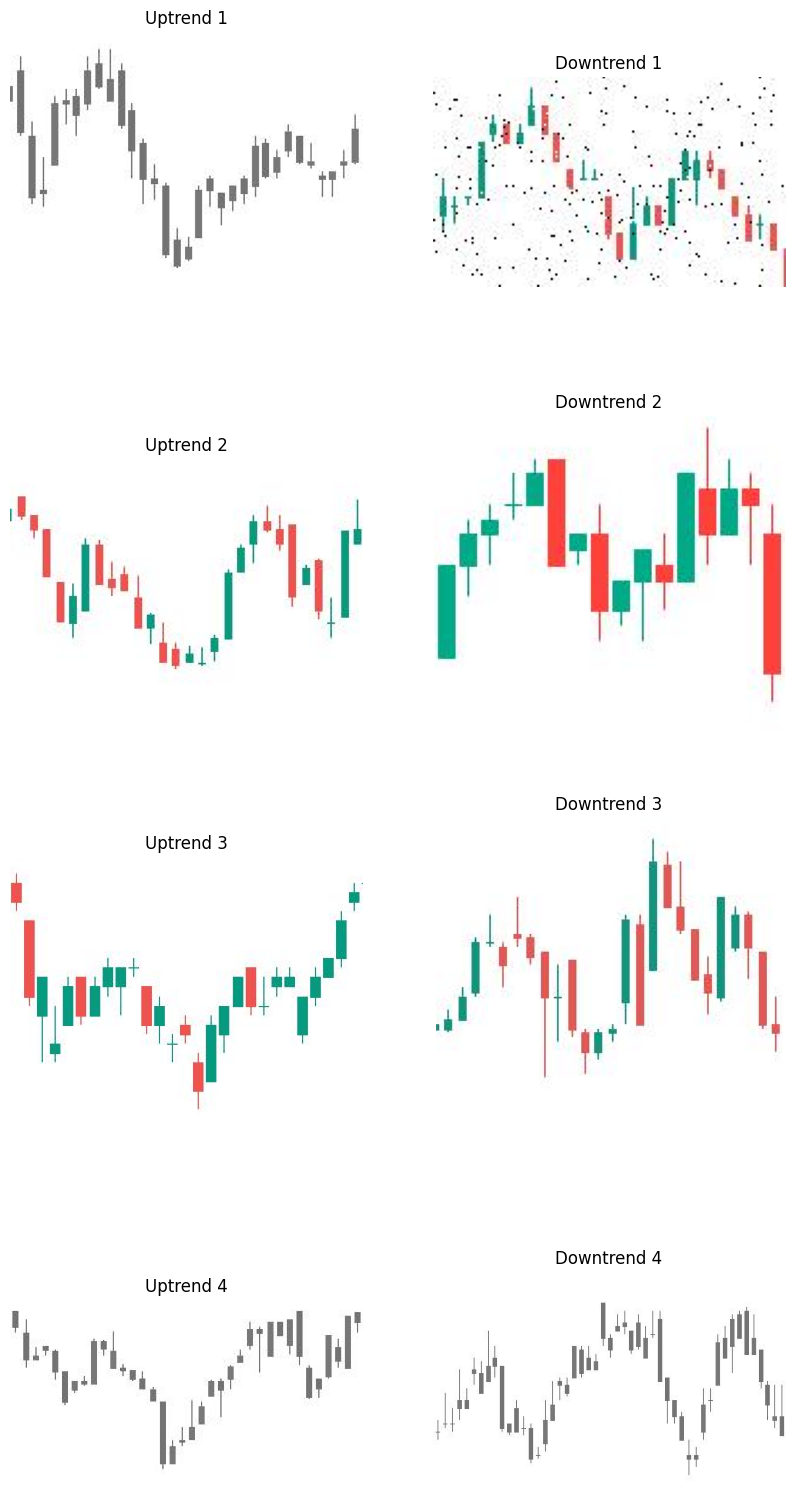

In [4]:
uptrend_list = [os.path.join(uptrend_dir, f) for f in os.listdir(uptrend_dir)]
downtrend_list = [os.path.join(downtrend_dir, f) for f in os.listdir(downtrend_dir)]

plt.figure(figsize=(10, 20))
for i in range(4):
    # Read and display uptrend image
    img_up = cv2.imread(uptrend_list[i])
    img_up = cv2.cvtColor(img_up, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 2, 2 * i + 1)  # Position in subplot (left column)
    plt.imshow(img_up)
    plt.title(f'Uptrend {i+1}')
    plt.axis('off')

    # Read and display downtrend image
    img_down = cv2.imread(downtrend_list[i])
    img_down = cv2.cvtColor(img_down, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 2, 2 * i + 2)  # Position in subplot (right column)
    plt.imshow(img_down)
    plt.title(f'Downtrend {i+1}')
    plt.axis('off')

plt.show()

### Training

In [27]:
base_dir = r"/kaggle/input/stock-chart-classification-dataset/chart trend dataset"

image_size = (224, 224)
batch_size = 32

data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [28]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(base_dir)
len(image_df)

928

In [37]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

test_gen = ImageDataGenerator(
    rescale=1./255
)

In [38]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True,
    seed=42
)


val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 631 validated image filenames belonging to 2 classes.
Found 111 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.


In [63]:
# pretrained_model= ResNet50(include_top=False,
#                    input_shape=(224,224,3),
#                    pooling='avg',
#                    classes=2,
#                    weights='imagenet')

# for layer in pretrained_model.layers:
#         layer.trainable=False

# resnet_model = Sequential([
#     Input(shape=(224, 224, 3)),
#     pretrained_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(256, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(2, activation='softmax')
# ])

# resnet_model.compile(optimizer='adam',
#                      loss='categorical_crossentropy',metrics=['accuracy'])

# resnet_model.summary()


model = Sequential([
    Input(shape=(224,224,3)),

    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2),strides=(2,2)),

    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2),strides=(2,2)),

    Flatten(),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(2,activation='softmax')
])

model.compile(optimizer='adam',
                     loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,828,546 (182.45 MB)

 Trainable params: 47,828,546 (182.45 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
checkpoint_path = "/kaggle/working/chart_model.h5"

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [66]:
history = model.fit(
    train_data,
    steps_per_epoch = train_data.samples // batch_size,
    epochs = 30,
    validation_data = val_data,
    validation_steps = val_data.samples // batch_size,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5865 - loss: 3.9678
Epoch 1: val_loss improved from inf to 0.19296, saving model to /kaggle/working/chart_model.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 415ms/step - accuracy: 0.5924 - loss: 3.8662 - val_accuracy: 0.9792 - val_loss: 0.1930
Epoch 2/30
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.1922
Epoch 2: val_loss did not improve from 0.19296
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.1922 - val_accuracy: 0.9375 - val_loss: 0.2280
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9607 - loss: 0.1462
Epoch 3: val_loss improved from 0.19296 to 0.04835, saving model to /kaggle/working/chart_model.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.9610 - loss: 0.1444 - val_accuracy: 0.9792 - val_loss: 0.0483
Epoch 4/30
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9688 - loss: 0.1782
Epoch 4: val_loss improved from 0.04835 to 0.04646, saving model to

In [68]:
val_loss,val_acc = model.evaluate(test_data,steps= test_data.samples // batch_size)

print(f"Testing accuracy: {round(val_acc, 4)*100}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9889 - loss: 0.1869
Testing accuracy: 98.75%


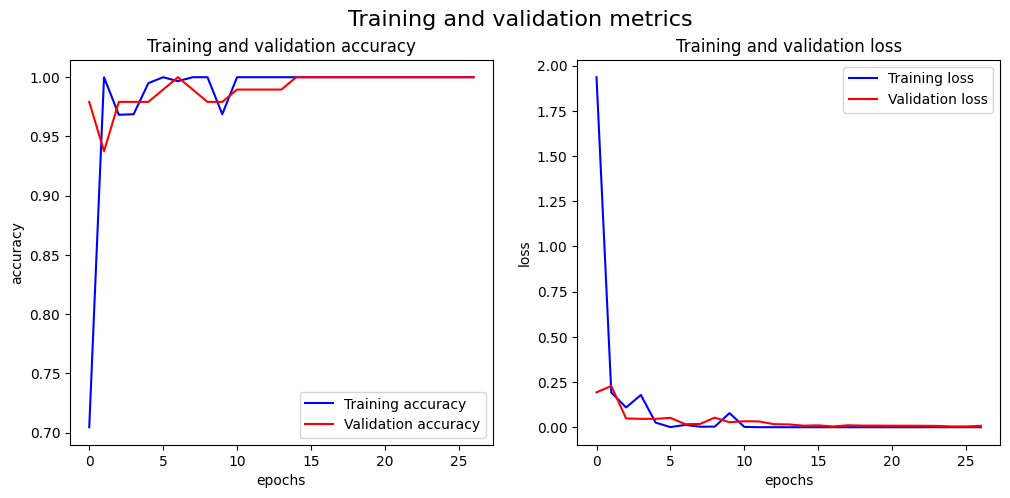

In [69]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


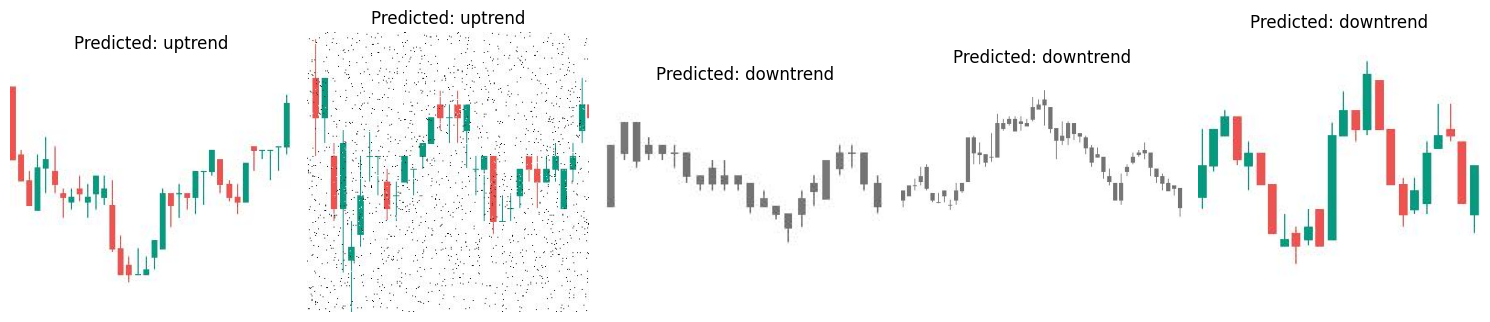

In [76]:
pred = model.predict(test_data)
pred_class_indices = np.argmax(pred, axis=1)

labels = test_data.class_indices
labels = dict((v, k) for k, v in labels.items())
pred_labels = [labels[i] for i in pred_class_indices]

# Step 3: Get image file paths (assuming test_data was created with flow_from_dataframe)
filepaths = test_data.filepaths

# Step 4: Plot 5 images with predictions
plt.figure(figsize=(15, 6))
for i in range(5):
    img = plt.imread(filepaths[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {pred_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [82]:
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
The first 5 predictions: ['uptrend', 'uptrend', 'downtrend', 'downtrend', 'downtrend']


,precision,recall,f1-score,support
downtrend,0.977778,1.000000,0.988764,88.000000
uptrend,1.000000,0.979592,0.989691,98.000000
accuracy,0.989247,0.989247,0.989247,0.989247
macro avg,0.988889,0.989796,0.989227,186.000000
weighted avg,0.989486,0.989247,0.989252,186.000000
